In [1]:
import numpy as np
from scipy.linalg import orth

In [2]:
def lrr(X, lamda, itr_max, norm_choice=0):
  # returns the LRR
  # norm choices:
  # 0 : max element in X
  # 1 : infinity norm
  # 2 : l2 norm
  # 3 : l1 norm
  # 4 : l-2 norm (smallest singular value)
  # 5 : l-1 norm (smallest  absolute row sum)

  A = X
  P = orth(A.T)
  B = np.dot(A, P)
  d, n = X.shape
  m = B.shape[1]

  # initial values
  Z = np.zeros((m,n), dtype=np.float32)
  J = np.zeros((m,n), dtype=np.float32)
  E = np.zeros((d,n), dtype=np.float32)
  Y1 = np.zeros((d,n), dtype=np.float32)
  Y2 = np.zeros((m,n), dtype=np.float32)
  mu = 1.0E-6
  mu_max = 1.0E+10
  rho = 1.1
  epsilon = 1.0E-8

  itr = 0

  params = []
  while itr < itr_max:
    itr = itr + 1
    # if itr % 100 == 0:
    #   print('LRR itr=',itr)
    #   print('Convergence:', max(norm_eq1,norm_eq2))

    # optimizing over J (Step 1)
    Y = Z + Y2/mu
    U, sdiag, Vh = np.linalg.svd(Y, full_matrices=False)
    V = Vh.T
    r = sum(sdiag > 1.0/mu)
    if r == 0:
      sigma_thres = [0]
    else:
      sigma_thres = sdiag[0:r+1] - 1.0/mu
    Usigma = np.dot( U[:,0:r+1], np.diag(sigma_thres) )
    J = np.dot( Usigma, V[:,0:r+1].T );

    # optimizing over Z (Step 2)
    factor1 = np.linalg.inv( np.identity(m) + np.dot(B.T,B) )
    factor2 = np.dot( B.T,(X-E) ) + J + ( np.dot(B.T,Y1)-Y2 )/mu
    Z = np.dot( factor1, factor2 )
    rank_Z = np.linalg.matrix_rank(Z)

    # optimizing over E (Step 3)
    alpha = lamda/mu
    Q = X - np.dot(B,Z) + Y1/mu
    for i in range( Q.shape[1] ):
      q = Q[:,[i]]
      q_norm = np.linalg.norm( q,2 )
      if q_norm > alpha:
        scalar = (q_norm - alpha) / q_norm
        E[:,[i]] = scalar * q
      else:
        E[:,[i]] = np.zeros((d,1))

    # updating multipliers (Step 4)
    eq1 = X - np.dot(B,Z) - E
    eq2 = Z - J
    Y1 = Y1 + mu*eq1
    Y2 = Y2 + mu*eq2

    # updating mu (Step 5)
    mu = min( rho*mu, mu_max )

    # convergence conditions (Step 6)
    norm_eq1 = 0
    norm_eq2 = 0
    if(norm_choice==0): # paper inf
      norm_eq1 = np.amax( np.abs(eq1) )
      norm_eq2 = np.amax( np.abs(eq2) )
    elif (norm_choice==1): # actual inf
      norm_eq1 = np.linalg.norm(eq1, np.inf)
      norm_eq2 = np.linalg.norm(eq2, np.inf)
    elif (norm_choice==2): # l2
      norm_eq1 = np.linalg.norm(eq1, 2)
      norm_eq2 = np.linalg.norm(eq2, 2)
    elif (norm_choice==3): # l1
      norm_eq1 = np.linalg.norm(eq1, 1)
      norm_eq2 = np.linalg.norm(eq2, 1)
    elif (norm_choice==4): # l-2
      norm_eq1 = np.linalg.norm(eq1, -2)
      norm_eq2 = np.linalg.norm(eq2, -2)
    elif (norm_choice==5): # l-1
      norm_eq1 = np.linalg.norm(eq1, -1)
      norm_eq2 = np.linalg.norm(eq2, -1)

    params.append( {'mu':mu, 'max_norm_eq':max(norm_eq1,norm_eq2), 'r':r, 'rank_Z':rank_Z, 'iter':itr} )

    if norm_eq1 < epsilon and norm_eq2 < epsilon:
      break

  return np.dot(P,Z), E, params
  # returns Z_star, E_star, dictionary of parameter values at each iteration

In [3]:
!rm -r /content/subspace-segmentation-via-low-rank-representation/
!git clone https://github.com/kaushal-k/subspace-segmentation-via-low-rank-representation.git

rm: cannot remove '/content/subspace-segmentation-via-low-rank-representation/': No such file or directory
Cloning into 'subspace-segmentation-via-low-rank-representation'...
remote: Enumerating objects: 520, done.
remote: Counting objects: 100% (520/520), done.
remote: Compressing objects: 100% (436/436), done.
remote: Total 520 (delta 79), reused 520 (delta 79), pack-reused 0
Receiving objects: 100% (520/520), 31.63 MiB | 35.83 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [4]:
import os
from scipy.io import loadmat
from sklearn.cluster import KMeans
from itertools import permutations

In [5]:
def affinity_matrix(Z_star):
  # Z_star : LRR
  # returns the affinity matrix

  # Step 2
  U, sdiag, Vh = np.linalg.svd(Z_star, full_matrices=False)
  V = Vh.T
  zero_thres = 0.0001 * sdiag[0]
  r = sum( sdiag > zero_thres )
  U = U[:,0:r+1]
  sdiag = sdiag[0:r+1]

  # Step 3
  U_tilda_inter = np.dot( U, np.diag(np.sqrt(sdiag)) )
  U_tilda = U_tilda_inter / np.linalg.norm(U_tilda_inter, ord=2, axis=1, keepdims=True)
  W = np.square( np.dot(U_tilda,U_tilda.T) )
  W = np.square( W )

  return W

In [6]:
def spectral_clustering(W,K):
  # W : affinity matrix
  # K : no. of subspace clusters
  # NCut clustering

  # Step 4 (Spectral Clustering)
  Ddiag = 1.0 / np.sqrt( W.sum(axis=1, dtype=np.float) )
  D = np.diag(Ddiag)
  L = np.dot( D, np.dot(W,D) )
  U, s, Vh = np.linalg.svd(L)
  V = U[:,0:K]
  V = np.dot( D,V )
  res = KMeans(n_clusters=K, init='k-means++', random_state=1).fit_predict(V)
  res = res + 1

  return res

In [7]:
def motion_seg(lamda, lrr_itr_max, norm_choice):  
  # motion segmentation on Hopkins155 datset
  dataset = []
  error = []
  params = []
  last_exec = ''

  # hopkins155_path = '/content/ee609_data/Hopkins155/'
  hopkins155_path = '/content/subspace-segmentation-via-low-rank-representation/Data/Hopkins155/'
  for dir in os.listdir(hopkins155_path):
    if os.path.isdir(hopkins155_path+dir):
      data = loadmat(hopkins155_path+dir+'/'+dir+'_truth.mat')
      # frames x points (a tracked point is one sample in this one motion sequnce)
      X = np.concatenate([ data['x'][0,:,:].T, data['x'][1,:,:].T ])
      row_ones = np.ones( (1,X.shape[1]), dtype=np.float32 )
      X = np.concatenate( [X, row_ones] )
      S = data['s']
      dataset.append( {'name':dir, 'X':X, 'seg_ids':S} )

  for data in dataset:
    print('Working on: ', data['name'])

    last_exec = data['name']

    # given number of subspace segments
    K = np.amax( data['seg_ids'] )

    # Step 1 (Low-Rank Representation)
    Z_star, E_star, params = lrr(data['X'], lamda, lrr_itr_max, norm_choice)

    # Steps 2 & 3 (Affinity Matrix)
    W = affinity_matrix(Z_star)

    res = spectral_clustering(W,K)

    # errors
    rng = [*range(1,K+1,1)]
    perms = list( permutations(rng) )
    perms = np.array(perms)
    perms = np.flip(perms, axis=0)
    perms_dim = perms.shape[0]
    miss = np.zeros( (perms_dim,1), dtype=np.float32 )
    for i in range(perms_dim):
      absol = np.abs( res[:] - perms[ i, data['seg_ids'].T-1 ] )
      absol = absol > 0.1
      miss[i,0] = np.sum(absol)
    seg_err = 1.0*np.amin(miss) / res.shape[0]
    error.append(seg_err)

  return error, params, last_exec
  # last_exec: file name of last data that was worked upon
  # params: list of dictionary with keys mu, r, max_norm_eq, and iter, depicting evolution over iterations (corresponding to last_exec)

In [8]:
# Run this and the next 2 cells for norm_choice = 0, but different values of lamda_motion = 1, 2, 3, 3.6, 4, 4.6, 6, 7 to obtain plots and error results
# Run this and the next 2 cells for lamda_motion=4.6, but different values of norm_choice = 0, 1, 2, 3, 4, 5
# (One run of this cell will take about 25-30 mins)

lamda_motion = 4.6
max_iter_motion = 500
norm_choice = 0
error, params, last_exec = motion_seg(lamda_motion, max_iter_motion, norm_choice)

Working on:  2T3RCR_g13
Working on:  1R2RC
Working on:  cars5
Working on:  cars2_07_g12
Working on:  cars2B_g23
Working on:  2T3RCRT_g12
Working on:  cars10
Working on:  cars5_g13
Working on:  two_cranes_g23
Working on:  2R3RTCRT
Working on:  cars2_06_g13
Working on:  people1
Working on:  people2
Working on:  cars2_06_g12
Working on:  cars8
Working on:  2R3RTC_g13
Working on:  cars1
Working on:  2RT3RTCRT
Working on:  1RT2TC_g13
Working on:  1R2RC_g12
Working on:  2T3RCRTP
Working on:  2T3RCRT_g23
Working on:  cars10_g23
Working on:  2RT3RCR_g23
Working on:  2RT3RCT_B_g12
Working on:  2RT3RCT_A_g12
Working on:  1R2RCT_A_g13
Working on:  1R2RCT_B_g13
Working on:  cars4
Working on:  1RT2RCR_g13
Working on:  2R3RTCRT_g12
Working on:  1R2RCT_B
Working on:  2RT3RCT_A_g23
Working on:  1R2RCR
Working on:  1RT2RCR
Working on:  2T3RCRTP_g23
Working on:  cars3
Working on:  cars2_07_g23
Working on:  cars3_g23
Working on:  1RT2TC
Working on:  1RT2TC_g23
Working on:  2RT3RCR
Working on:  2RT3RC_g12

In [9]:
# to calulcate errors
from statistics import mean, stdev
print('motion segmentation error statistics on hopkins155')
print('lamda=',lamda_motion)
print('max_iter=',max_iter_motion)
print('norm_choice=', norm_choice)
print('mean error',mean(error))
print('stdev error', stdev(error))
print('max error', max(error))
print('min error', min(error))

motion segmentation error statistics on hopkins155
lamda= 4.6
max_iter= 500
norm_choice= 0
mean error 0.017213136077969312
stdev error 0.048956981307033985
max error 0.3333333333333333
min error 0.0


lamda= 4.6
max_iter= 500
norm_choice= 0
Parameter Evolution with iterations for motion_seg in file: 2R3RTC_g12
Final values:
mu: 112680.02566852688  r: 9  max_norm_eq: 9.976372075670703e-09 rank_Z: 59  iters: 267 



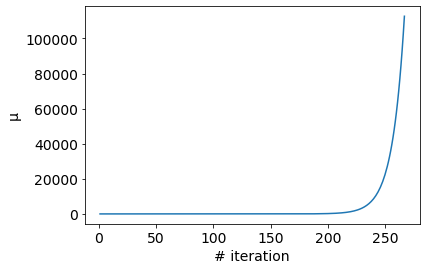

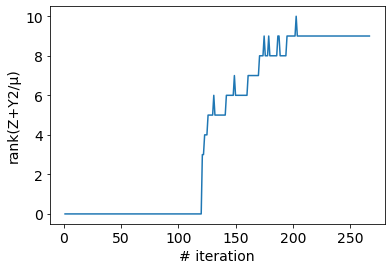

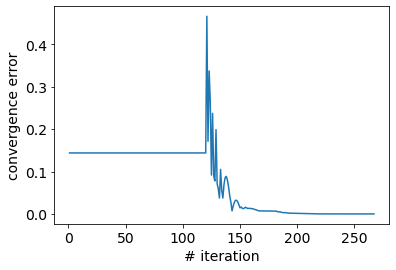

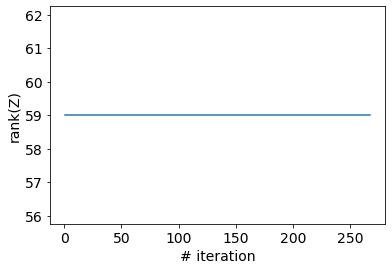

In [10]:
import matplotlib.pyplot as plt
print('lamda=',lamda_motion)
print('max_iter=',max_iter_motion)
print('norm_choice=', norm_choice)

print('Parameter Evolution with iterations for motion_seg in file:', last_exec)
iters = []
mus = []
rs = []
rank_Zs = []
max_norm_eqs = []
for d in params:
  iters.append(d['iter'])
  mus.append(d['mu'])
  rs.append(d['r'])
  rank_Zs.append(d['rank_Z'])
  max_norm_eqs.append(d['max_norm_eq'])

print('Final values:')
print('mu:',mus[-1], ' r:',rs[-1], ' max_norm_eq:',max_norm_eqs[-1], 'rank_Z:',rank_Zs[-1], ' iters:',iters[-1], '\n')

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14})
plt.plot(iters,mus)
plt.xlabel('# iteration')
plt.ylabel('\u03BC')
plt.show()

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14})
plt.plot(iters,rs)
plt.xlabel('# iteration')
plt.ylabel('rank(Z+Y2/\u03BC)')
plt.show()

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14})
plt.plot(iters,max_norm_eqs)
plt.xlabel('# iteration')
plt.ylabel('convergence error')
plt.show()

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14})
plt.plot(iters,rank_Zs)
plt.xlabel('# iteration')
plt.ylabel('rank(Z)')
plt.show()

In [11]:
def face_seg(lamda, lrr_itr_max, norm_choice):
  # face segmentation on yaleb10 dataset
  # yaleb_path = '/content/ee609_data/yaleb10.mat'
  yaleb_path = '/content/subspace-segmentation-via-low-rank-representation/Data/yaleb10.mat'
  data = loadmat(yaleb_path)
  X = data['obj'][0,0][0]
  seg_ids = data['obj'][0,0][1].T

  # given number of subspace segments
  K = np.amax(seg_ids)

  # Step 1 (Low-Rank Representation)
  Z_star, E_star, lrr_params = lrr(X,lamda,lrr_itr_max, norm_choice)

  # Steps 2 & 3 (Affinity Matrix)
  W = affinity_matrix(Z_star)

  # Step 4 (NCut Spectral Clustering)
  res = spectral_clustering(W,K)
  copy_res = res

  # calculating accuracy
  unique_segs_exp = np.unique(res)
  for unique_seg_exp in unique_segs_exp:
    filter = (res == unique_seg_exp)
    gnd_filter = seg_ids[ filter ]
    unique_gnd = np.unique( gnd_filter )
    max_cnt = 0
    majority_label = 0
    for ug in unique_gnd:
      cnt = np.sum( gnd_filter==ug )
      if cnt > max_cnt:
        max_cnt = cnt
        majority_label = ug
    res[ filter ] = majority_label
  res = np.reshape( res, (res.shape[0],1) )
  acc = np.sum( res==seg_ids ) / res.shape[0]

  return copy_res, res, acc, lrr_params

In [12]:
# Run this and the next 1 cell for norm_choice=0, but different lamda_face = 0.06, 0.1, 0.12, 0.14, 0.16, 0.18, 0.20, 0.22
# Run this and the next 1 cell for lamda_face = 0.16, but different norm_choice = 0, 1, 2, 3, 4, 5
# (This cell will take about 7 mins)

lamda_face = 0.16
max_iters_face = 500
norm_choice = 0
copy_res, res, acc, lrr_params = face_seg(lamda_face,max_iters_face, norm_choice)

Face Segmentation
lamda= 0.16
max_iter= 500
norm_choice= 0
accuracy= 0.634375
Parameter Evolution with iterations for face_seg
Final values:
mu: 10000000000.0  r: 638  max_norm_eq: 3.8425021164911755e-08 rank_Z: 640  iters: 500 



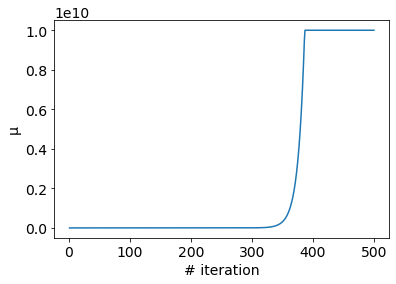

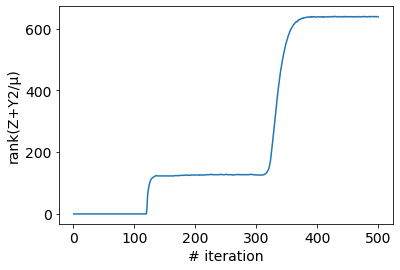

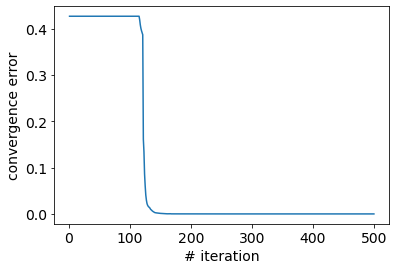

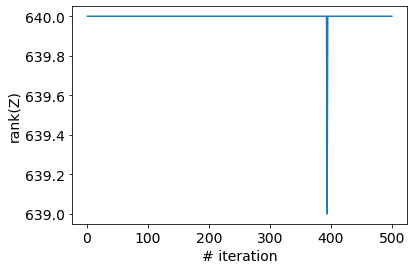

In [13]:
print('Face Segmentation')
print('lamda=', lamda_face)
print("max_iter=", max_iters_face)
print("norm_choice=", norm_choice)
print('accuracy=', acc)

print('Parameter Evolution with iterations for face_seg')
iters = []
mus = []
rs = []
rank_Zs = []
max_norm_eqs = []
for d in lrr_params:
  iters.append(d['iter'])
  mus.append(d['mu'])
  rs.append(d['r'])
  rank_Zs.append(d['rank_Z'])
  max_norm_eqs.append(d['max_norm_eq'])

print('Final values:')
print('mu:',mus[-1], ' r:',rs[-1], ' max_norm_eq:',max_norm_eqs[-1], 'rank_Z:',rank_Zs[-1], ' iters:',iters[-1], '\n')

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14})
plt.plot(iters,mus)
plt.xlabel('# iteration')
plt.ylabel('\u03BC')
plt.show()

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14})
plt.plot(iters,rs)
plt.xlabel('# iteration')
plt.ylabel('rank(Z+Y2/\u03BC)')
plt.show()

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14})
plt.plot(iters,max_norm_eqs)
plt.xlabel('# iteration')
plt.ylabel('convergence error')
plt.show()

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14})
plt.plot(iters,rank_Zs)
plt.xlabel('# iteration')
plt.ylabel('rank(Z)')
plt.show()

In [14]:
def soft_thres(s, t):
  res = np.zeros( s.shape, dtype=np.float32 )
  res[ s>=t ] = 1.0
  res[ s<t ] = np.log( 1.0 + np.square(s[s<t]/t) )
  return res

In [15]:
def motion_seg_k(lamda, lrr_itr_max, t, norm_choice=0):
  # Estimating number of subspace segments
  dataset = []
  error1 = []
  params = []
  last_exec = ''
  num_pred = 0

  # hopkins155_path = '/content/ee609_data/Hopkins155/'
  hopkins155_path = '/content/subspace-segmentation-via-low-rank-representation/Data/Hopkins155/'
  for dir in os.listdir(hopkins155_path):
    if os.path.isdir(hopkins155_path+dir):
      data = loadmat(hopkins155_path+dir+'/'+dir+'_truth.mat')
      # frames x points (a tracked point is one sample in this one motion sequnce)
      X = np.concatenate([ data['x'][0,:,:].T, data['x'][1,:,:].T ])
      row_ones = np.ones( (1,X.shape[1]), dtype=np.float32 )
      X = np.concatenate( [X, row_ones] )
      S = data['s']
      dataset.append( {'name':dir, 'X':X, 'seg_ids':S} )
  
  for data in dataset:
    print('Working on file: ', data['name'])

    K = np.amax( data['seg_ids'] )

    last_exec = data['name']
    Z_star, E_star, params = lrr(data['X'], lamda, lrr_itr_max, norm_choice)
    W = affinity_matrix(Z_star)
    Ddiag = 1.0 / np.sqrt( W.sum(axis=1, dtype=np.float) )
    D = np.diag(Ddiag)
    DWD = np.dot( D, np.dot(W,D) )
    L = np.identity( DWD.shape[0] ) - DWD
    n = data['X'].shape[1]
    U,s,Vh = np.linalg.svd(L)
    soft_thres_s = soft_thres(s,t)
    k = int( n - np.sum(soft_thres_s) )
    err1 = 1.0*np.abs(K-k) / K
    error1.append( err1 )
    if(k == K):
      num_pred = num_pred + 1

  return error1, params, last_exec, num_pred


In [16]:
# Run this and the next 2 cells for lambda_k = 4, but different values of t_k = 0.06, 0.07, 0.08, 0.09, 0.10, 0.11
# One run of this cell will take about 25-30 mins

lamda_k = 4
lrr_itr_max_k = 500
t_k = 0.11
norm_choice = 0
error1, params, last_exec, num_pred = motion_seg_k(lamda_k, lrr_itr_max_k, t_k, norm_choice)

Working on file:  2T3RCR_g13
Working on file:  1R2RC
Working on file:  cars5
Working on file:  cars2_07_g12
Working on file:  cars2B_g23
Working on file:  2T3RCRT_g12
Working on file:  cars10
Working on file:  cars5_g13
Working on file:  two_cranes_g23
Working on file:  2R3RTCRT
Working on file:  cars2_06_g13
Working on file:  people1
Working on file:  people2
Working on file:  cars2_06_g12
Working on file:  cars8
Working on file:  2R3RTC_g13
Working on file:  cars1
Working on file:  2RT3RTCRT
Working on file:  1RT2TC_g13
Working on file:  1R2RC_g12
Working on file:  2T3RCRTP
Working on file:  2T3RCRT_g23
Working on file:  cars10_g23
Working on file:  2RT3RCR_g23
Working on file:  2RT3RCT_B_g12
Working on file:  2RT3RCT_A_g12
Working on file:  1R2RCT_A_g13
Working on file:  1R2RCT_B_g13
Working on file:  cars4
Working on file:  1RT2RCR_g13
Working on file:  2R3RTCRT_g12
Working on file:  1R2RCT_B
Working on file:  2RT3RCT_A_g23
Working on file:  1R2RCR
Working on file:  1RT2RCR
Working

In [17]:
from statistics import mean, stdev
print('error statistics on hopkins155 - K estimation')
print('lamda=',lamda_k)
print('tau=',t_k)
print('norm_choice=', norm_choice)
print('mean error1',mean(error1))
print('stdev error1', stdev(error1))
print('max error1', max(error1))
print('min error1', min(error1))
print('No. of predicted:', num_pred)


error statistics on hopkins155 - K estimation
lamda= 4
tau= 0.11
norm_choice= 0
mean error1 0.27286324786324784
stdev error1 0.2732468913189618
max error1 1.5
min error1 0.0
No. of predicted: 69



Parameter Evolution on file: 2R3RTC_g12
Final values:
mu: 123948.02823537958  r: 9  max_norm_eq: 9.711357579211821e-09 rank_Z: 59  iters: 268


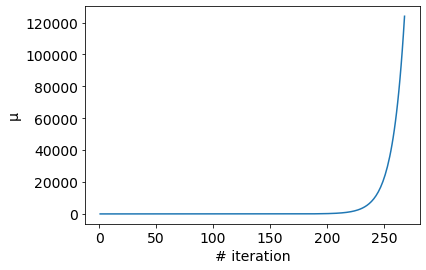

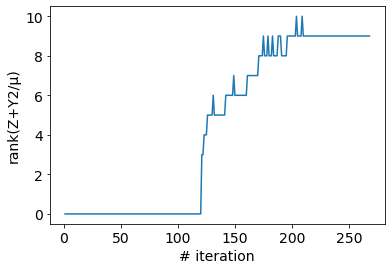

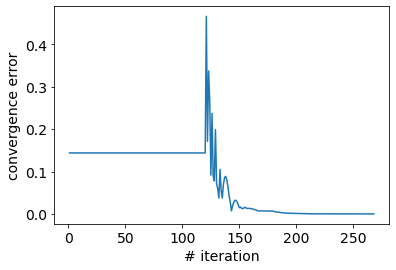

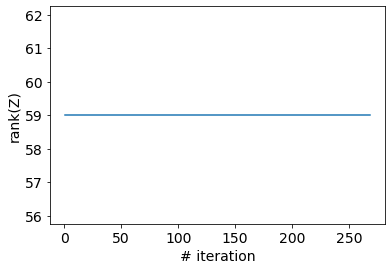

In [18]:
import matplotlib.pyplot as plt
print('\nParameter Evolution on file:', last_exec)
iters = []
mus = []
rs = []
rank_Zs = []
max_norm_eqs = []
for d in params:
  iters.append(d['iter'])
  mus.append(d['mu'])
  rs.append(d['r'])
  rank_Zs.append(d['rank_Z'])
  max_norm_eqs.append(d['max_norm_eq'])

print('Final values:')
print('mu:',mus[-1], ' r:',rs[-1], ' max_norm_eq:',max_norm_eqs[-1], 'rank_Z:',rank_Zs[-1], ' iters:',iters[-1])

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14})
plt.plot(iters,mus)
plt.xlabel('# iteration')
plt.ylabel('\u03BC')
plt.show()

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14})
plt.plot(iters,rs)
plt.xlabel('# iteration')
plt.ylabel('rank(Z+Y2/\u03BC)')
plt.show()

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14})
plt.plot(iters,max_norm_eqs)
plt.xlabel('# iteration')
plt.ylabel('convergence error')
plt.show()

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14})
plt.plot(iters,rank_Zs)
plt.xlabel('# iteration')
plt.ylabel('rank(Z)')
plt.show()

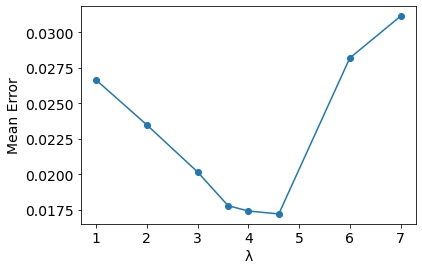

In [19]:
# motion_segmentation (mean error vs lamda plot)
# norm_choice = 0
lamda = np.array([1.0, 2.0, 3.0, 3.6, 4.0, 4.6, 6.0, 7.0])
mean_error = np.array([ 0.026637113764302226,  0.023475780703100305, 0.02016318489349344,  0.01779393939225322, 0.017418053639225082, 0.017213136077969312, 0.028186935117254917, 0.031127707291906805])
plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14})
plt.plot(lamda,mean_error,'-o')
plt.xlabel('\u03BB')
plt.ylabel('Mean Error')
plt.show()

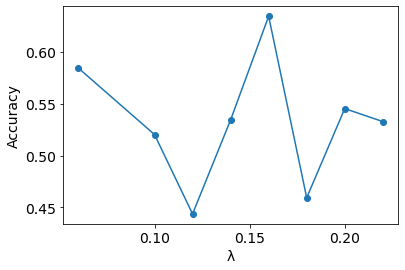

In [20]:
# face segmentation (yaleb10) (accuracy vs lambda plot)
# norm_choice = 0
lamda = np.array([0.06, 0.1, 0.12, 0.14, 0.16, 0.18, 0.20, 0.22])
acc = np.array([0.584375, 0.5203125, 0.44375, 0.534375, 0.634375, 0.459375, 0.5453125, 0.5328125])
plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14})
plt.plot(lamda,acc,'-o')
plt.xlabel('\u03BB')
plt.ylabel('Accuracy')
plt.show()